In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings('ignore')

---

General variables and dictionaries

In [2]:
VARIABLE = 'MonthlyIncome'
VARIABLE2 = 'Monthly income'

PREDICTOR = 'YearsOfEducation'
PREDICTOR2 = 'Years of education'

COMPARE_METRIC = 'waic' # metric for comparing the models, options are 'waic' or 'loo'

ALPHA_LEVEL = 0.05

J = 6 # Number of regions

In [3]:
RegionsToNumbers = {
    'NorthernThailand': 0
    , 'SouthernThailand': 2
    , 'WesternThailand': 3
    , 'EasternThailand': 5
    , 'NortheastThailand': 1
    , 'CentralThailand': 4
}

In [4]:
NumbersToRegions = {
    0: 'Northern Thailand'
    , 2: 'Southern Thailand'
    , 3: 'Western Thailand'
    , 5: 'Eastern Thailand'
    , 1: 'Northeast Thailand'
    , 4: 'Central Thailand'
}

In [5]:
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

---

Read the data and give it the basic needed structure

In [6]:
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Enriched/ProvincesProvinceIdRegion.csv")

In [7]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
Dat = pd.merge(Dat, ProvincesProvinceIdRegion)
Dat['RegionNumber'] = Dat['Region'].replace(RegionsToNumbers)

In [8]:
Dat = Dat[[VARIABLE + 'Mean', PREDICTOR, 'RegionNumber']]

In [9]:
PredictorMean = Dat[PREDICTOR].mean()

---

In [10]:
DatRegion = Dat[[PREDICTOR, 'RegionNumber']].groupby(['RegionNumber']).mean().reset_index()
DatRegion = DatRegion.rename(columns={PREDICTOR: PREDICTOR + 'Region'})

Dat = pd.merge(Dat, DatRegion)

Calculate the statistics per region

In [11]:
DatRegion = Dat[[VARIABLE + 'Mean', 'RegionNumber']].groupby(['RegionNumber']).agg(['mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '': 'RegionNumber'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'
    }
)

---

Estimate $\nu$ for all the data

In [12]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

HatNu = 2 * ES2**2 / VS2 + 4

---

Regression model with common $\alpha$ and $\beta$

In [13]:
with pm.Model() as ModelCommonAlphaCommonBeta:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')

    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic('MeanIncome', Alpha + Beta * (Dat[PREDICTOR] - PredictorMean))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma, observed=Dat[VARIABLE + 'Mean'])

Regression model with separate $\alpha$'s and $\beta$'s

In [14]:
with pm.Model() as ModelSeparateAlphaSeparateBeta:
    Alpha = pm.Flat('Alpha', shape=J)
    Beta  = pm.Flat('Beta', shape=J)

    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['RegionNumber']] + Beta[Dat['RegionNumber']] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma[Dat['RegionNumber']], observed=Dat[VARIABLE + 'Mean'])

---

In [15]:
TraceCommonAlphaCommonBeta = pm.sample(model = ModelCommonAlphaCommonBeta)
TraceSeparateAlphaSeparateBeta = pm.sample(model = ModelSeparateAlphaSeparateBeta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [16]:
HatMeanMu = TraceCommonAlphaCommonBeta.posterior.Alpha.values.mean()
HatStdMu  = TraceCommonAlphaCommonBeta.posterior.Alpha.values.std()

HatMeanTau = float(TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw')).std().values)

HatMeanGamma = TraceCommonAlphaCommonBeta.posterior.Beta.values.mean()
HatStdGamma  = TraceCommonAlphaCommonBeta.posterior.Beta.values.std()

HatMeanZeta = float(TraceSeparateAlphaSeparateBeta.posterior.Beta.mean(('chain', 'draw')).std().values)

---

In [17]:
with pm.Model() as ModelVaryingAlphaVaryingBeta:

    Chol, RhoAlphaBeta, CovAlphaBeta = pm.LKJCholeskyCov(
        "chol_cov"
        , n=2
        , eta=2
        , sd_dist=pm.Exponential.dist(lam=[1/HatMeanTau, 1/HatMeanZeta])
        , compute_corr=True
    )

    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu)
    Gamma = pm.Normal('Gamma', mu=HatMeanGamma, sigma=HatStdGamma)

    AlphaBeta = pm.MvNormal("AlphaBeta", mu=[Mu, Gamma], chol=Chol, shape=(J, 2))

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , AlphaBeta[Dat['RegionNumber'], 0] + AlphaBeta[Dat['RegionNumber'], 1] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region'])
    )

    Income = pm.Laplace(
        'Income'
        , mu = MeanIncome
        , b  = Sigma[Dat['RegionNumber']]
        , observed = Dat[VARIABLE + 'Mean']
    )

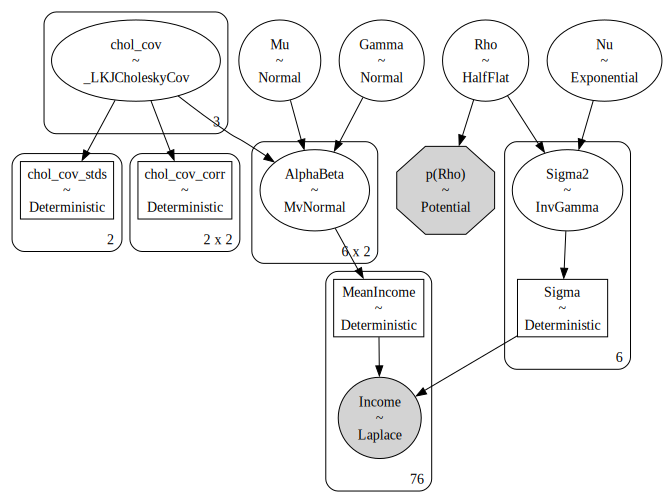

In [18]:
pm.model_to_graphviz(ModelVaryingAlphaVaryingBeta)

Get a sample from the posterior and the posterior predictive

In [19]:
with ModelVaryingAlphaVaryingBeta:
    TraceVaryingAlphaVaryingBeta = pm.sample()
    TraceVaryingAlphaVaryingBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaVaryingBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, Mu, Gamma, AlphaBeta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Income]


---

Regional average income, ratio of income per year-of-education

In [20]:
DatRegion['Region'] = DatRegion['RegionNumber'].replace(NumbersToRegions)

In [21]:
PosteriorAlpha = az.summary(
    TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,0]
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'AlphaBeta'
)

PosteriorAlpha = PosteriorAlpha.rename(
    columns = {
        'mean': 'HatAlpha'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowAlpha'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppAlpha'
    }
)

In [22]:
PosteriorBeta = az.summary(
    TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,1]
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'AlphaBeta'
)

PosteriorBeta = PosteriorBeta.rename(
    columns = {
        'mean': 'HatBeta'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowBeta'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppBeta'
    }
)

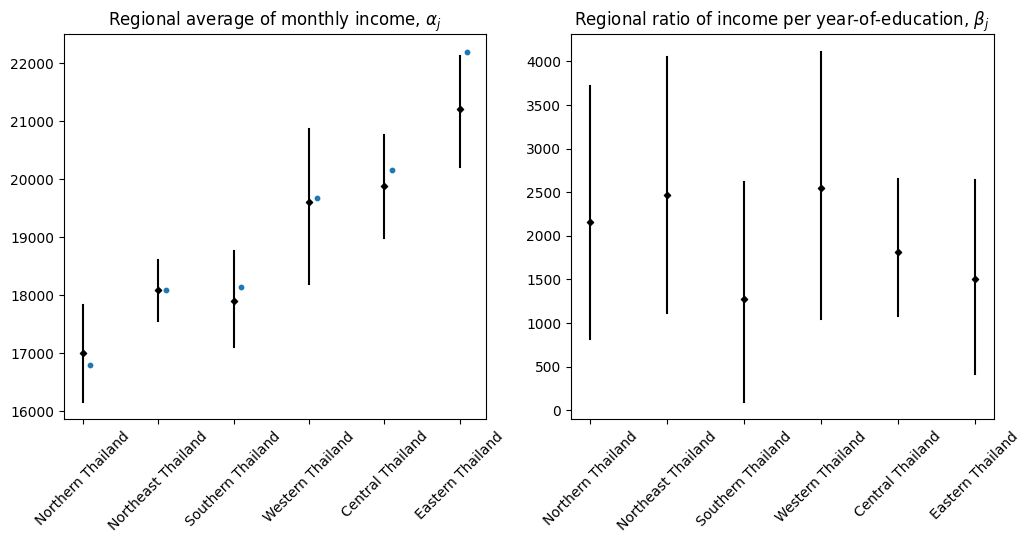

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for k, ax in enumerate(axs.reshape(-1)):
    if k == 0:
        ax.scatter(range(J), PosteriorAlpha['HatAlpha'], marker='D', color='k', s=10)
        ax.scatter(np.arange(0.1, J+0.1, 1), DatRegion[VARIABLE + 'Mean'], marker='o', color='C0', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorAlpha['LowAlpha'][j], PosteriorAlpha['UppAlpha'][j]],
                color='k'
            )

        ax.set_title(r'Regional average of monthly income, $\alpha_j$')
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)
    else:
        ax.scatter(range(J), PosteriorBeta['HatBeta'], marker='D', color='k', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorBeta['LowBeta'][j], PosteriorBeta['UppBeta'][j]],
                color='k'
            )
            
        ax.set_title(r"Regional ratio of income per year-of-education, $\beta_j$")
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)

Text(0.5, 1.0, 'National ratio of income per year-of-education, $\\gamma$')

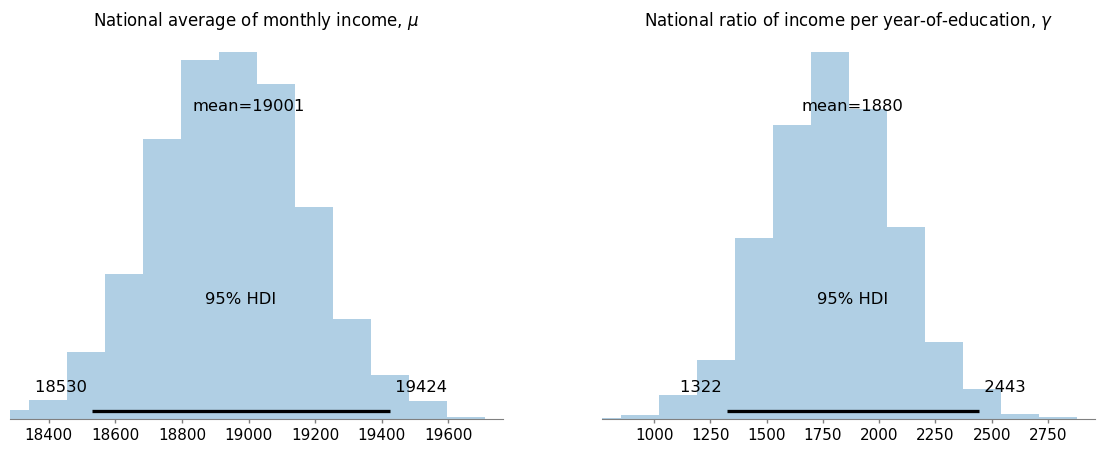

In [24]:
_, axes = plt.subplots(1,2, figsize=(14,5))

az.plot_posterior(
    TraceVaryingAlphaVaryingBeta
    , var_names = ['Mu', 'Gamma']
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize=11
    , ax = axes
)

axes[0].set_title(r"National average of monthly income, $\mu$")
axes[1].set_title(r"National ratio of income per year-of-education, $\gamma$")

In [42]:
PosteriorBeta.round()

,HatBeta,sd,LowBeta,UppBeta
AlphaBeta[0],2159.0,742.0,814.0,3719.0
AlphaBeta[1],2466.0,768.0,1111.0,4056.0
AlphaBeta[2],1278.0,655.0,94.0,2613.0
AlphaBeta[3],2545.0,819.0,1051.0,4109.0
AlphaBeta[4],1818.0,406.0,1076.0,2648.0
AlphaBeta[5],1509.0,577.0,413.0,2642.0


In [44]:
az.summary(
    TraceVaryingAlphaVaryingBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Gamma'
).round()

,mean,sd,hdi_2.5%,hdi_97.5%
Gamma,1880.0,285.0,1322.0,2443.0


In [27]:
if False:
    _, axes = plt.subplots(2,3, figsize=(18,10))

    az.plot_posterior(
        TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,0]
        , hdi_prob = 1-ALPHA_LEVEL
        , kind = 'hist'
        , textsize=11
        , ax = axes
    )

    for i in range(2):
        for j in range(3):
            axes[i,j].set_title(NumbersToRegions[3*i+j])

    plt.suptitle(r"Regional average of monthly income, $\alpha_j$")

In [28]:
if False:
    _, axes = plt.subplots(2,3, figsize=(18,10))

    az.plot_posterior(
        TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,1]
        , hdi_prob = 1-ALPHA_LEVEL
        , kind = 'hist'
        , textsize=11
        , ax = axes
    )

    for i in range(2):
        for j in range(3):
            axes[i,j].set_title(NumbersToRegions[3*i+j])

    plt.suptitle(r"Regional ratio of income per year-of-education, $\beta_j$")

---

We obtain the average distribution for $\alpha, \beta$

In [29]:
MeanMuGamma = np.array(
    [float(TraceVaryingAlphaVaryingBeta.posterior.Mu.mean()), float(TraceVaryingAlphaVaryingBeta.posterior.Gamma.mean())]
)

CholModel = pm.expand_packed_triangular(
    2, TraceVaryingAlphaVaryingBeta.posterior.chol_cov.mean(dim=("chain", "draw")).values, lower=True
).eval()

SigmaAlphaBeta = np.dot(CholModel, CholModel.T)

We see how changes from separate models and complete pooling to the partial pooled model

In [30]:
AlphaCommon = TraceCommonAlphaCommonBeta.posterior.Alpha.mean(('chain', 'draw'))
BetaCommon = TraceCommonAlphaCommonBeta.posterior.Beta.mean(('chain', 'draw'))

AlphaSeparate = TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw'))
BetaSeparate = TraceSeparateAlphaSeparateBeta.posterior.Beta.mean(('chain', 'draw'))

AlphaBetaPartialPooled = TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta.mean(('chain', 'draw')).T
AlphaPartialPooled = AlphaBetaPartialPooled[0]
BetaPartialPooled = AlphaBetaPartialPooled[1]

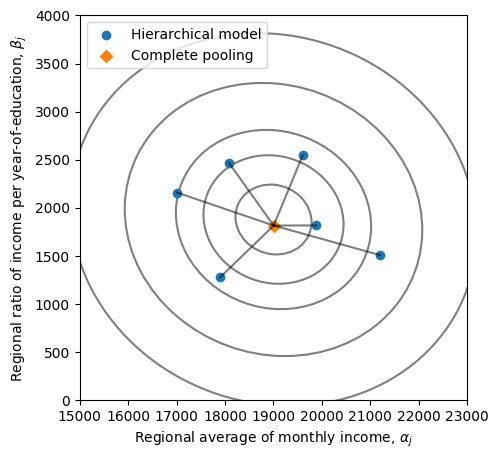

In [40]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(AlphaPartialPooled, BetaPartialPooled, label="Hierarchical model")
ax.scatter(AlphaCommon, BetaCommon, label="Complete pooling", marker='D')

ax.plot([[AlphaCommon]*J, AlphaPartialPooled], [[BetaCommon]*J, BetaPartialPooled], "k-", alpha=0.5)

ax.set_xlabel(r"Regional average of monthly income, $\alpha_j$")
ax.set_ylabel(r"Regional ratio of income per year-of-education, $\beta_j$")
ax.set_xlim(15000, 23000)
ax.set_ylim(00, 4000)
plt.legend(loc='upper left', fontsize=10)

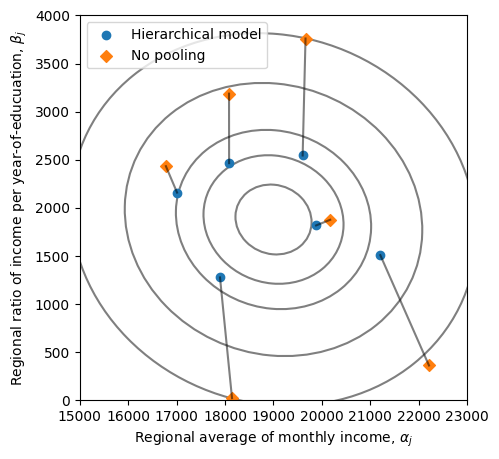

In [41]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(AlphaPartialPooled, BetaPartialPooled, label="Hierarchical model")
ax.scatter(AlphaSeparate, BetaSeparate, label="No pooling", marker='D')

ax.plot([AlphaSeparate, AlphaPartialPooled], [BetaSeparate, BetaPartialPooled], "k-", alpha=0.5)

ax.set_xlabel(r"Regional average of monthly income, $\alpha_j$")
ax.set_ylabel(r"Regional ratio of income per year-of-educuation, $\beta_j$")
ax.set_xlim(15000, 23000)
ax.set_ylim(00, 4000)
plt.legend(loc='upper left', fontsize=10)

---

Scatterplot

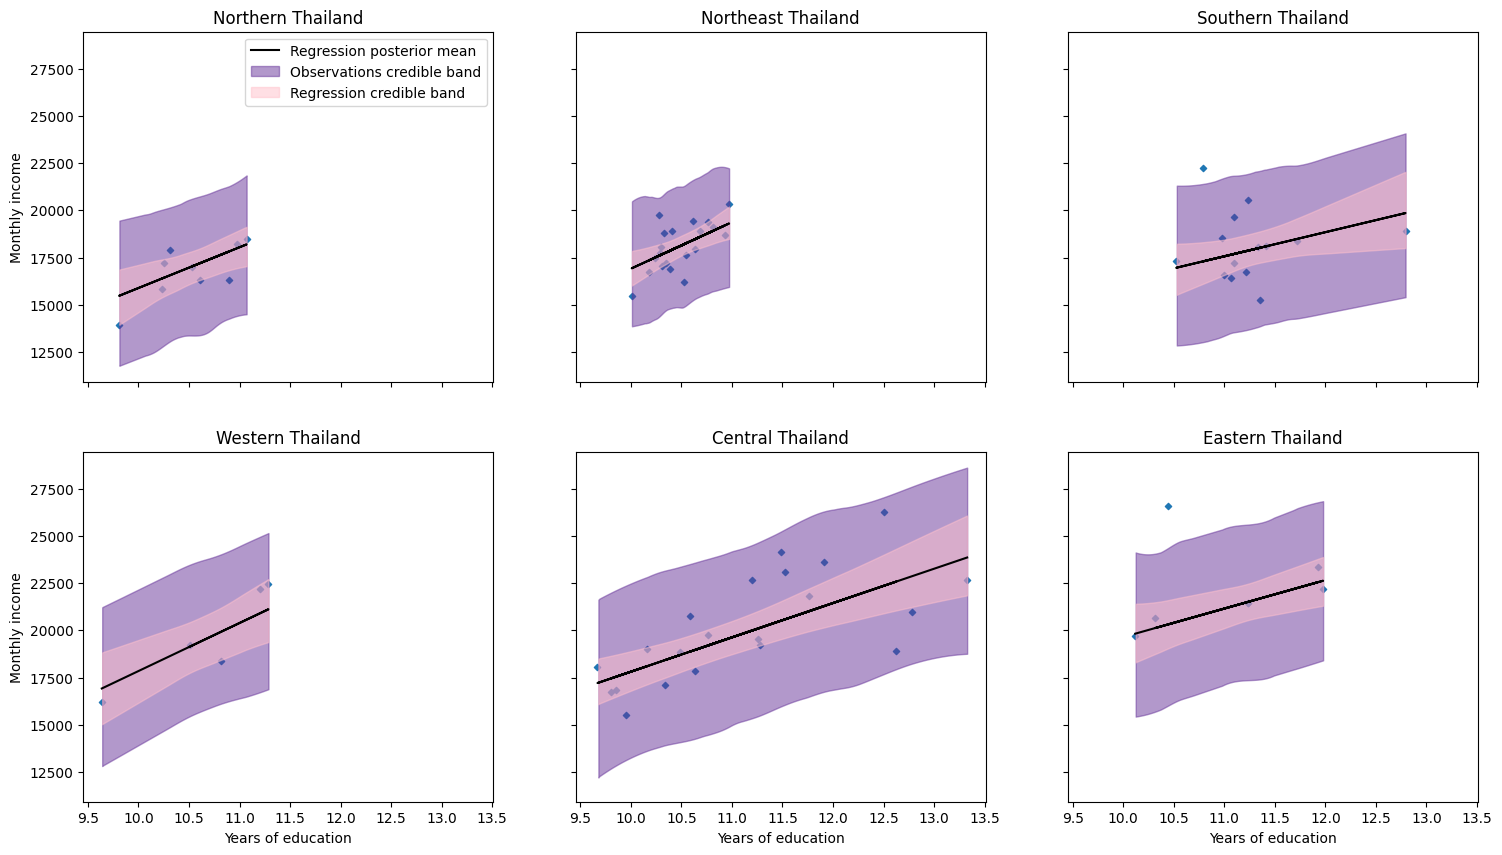

In [33]:
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(18,10))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = Dat[Dat['RegionNumber']==k]

    ax.scatter(
        Aux[PREDICTOR]
        , Aux[VARIABLE + 'Mean']
        , marker = 'D'
        , s = 10
    )

    ax.plot(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior.MeanIncome[:,:,Aux.index].mean(('chain', 'draw'))
        , label="Regression posterior mean"
        , color='k'
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior_predictive.Income[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='rebeccapurple'
        , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
        , ax = ax
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior.MeanIncome[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='pink'
        , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
        , ax = ax
    )

    ax.set_title(NumbersToRegions[k])

    if k in [0,3]:
        ax.set_ylabel(VARIABLE2)
        
        if k == 0:
            ax.legend()

    if k in [3,4,5]:
        ax.set_xlabel(PREDICTOR2)

---

Comparing the models

In [34]:
with pm.Model() as ModelVaryingAlphaCommonBeta:

    Tau   = pm.Exponential('Tau', lam=1/HatMeanTau)
    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu) # National average income
    Alpha = pm.Normal('Alpha', mu=Mu, sigma=Tau, shape=J) # Regional average income

    Beta = pm.Normal('Beta', mu=HatMeanGamma, sigma=HatStdGamma)

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['RegionNumber']] + Beta * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal(
        'Income'
        , mu = MeanIncome
        , sigma = Sigma[Dat['RegionNumber']]
        , observed = Dat[VARIABLE + 'Mean']
    )

Get a sample from the posterior and the posterior predictive

In [35]:
with ModelVaryingAlphaCommonBeta:
    TraceVaryingAlphaCommonBeta = pm.sample()
    TraceVaryingAlphaCommonBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaCommonBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tau, Mu, Alpha, Beta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
Sampling: [Income]


Calculate the WAIC of the models

In [36]:
pm.compute_log_likelihood(TraceCommonAlphaCommonBeta, model = ModelCommonAlphaCommonBeta)
pm.compute_log_likelihood(TraceSeparateAlphaSeparateBeta, model = ModelSeparateAlphaSeparateBeta)
pm.compute_log_likelihood(TraceVaryingAlphaCommonBeta, model = ModelVaryingAlphaCommonBeta)
pm.compute_log_likelihood(TraceVaryingAlphaVaryingBeta, model = ModelVaryingAlphaVaryingBeta)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [37]:
CompareTable = az.compare(
    {
        "National Model": TraceCommonAlphaCommonBeta
        , "Separate Model": TraceSeparateAlphaSeparateBeta
        , "Varying Intercept, Same Slope": TraceVaryingAlphaCommonBeta
        , "Varying Intercept, Varying Slope": TraceVaryingAlphaVaryingBeta
    }
    , ic = COMPARE_METRIC
    , scale = 'deviance'
)

In [38]:
CompareTable.round(2)

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
"Varying Intercept, Varying Slope",0,1354.28,14.32,0.00,0.29,16.15,0.00,True,deviance
"Varying Intercept, Same Slope",1,1354.69,10.89,0.41,0.49,17.46,5.60,True,deviance
Separate Model,2,1359.18,15.13,4.90,0.22,13.08,8.49,True,deviance
National Model,3,1387.05,4.06,32.77,0.00,18.30,11.97,True,deviance


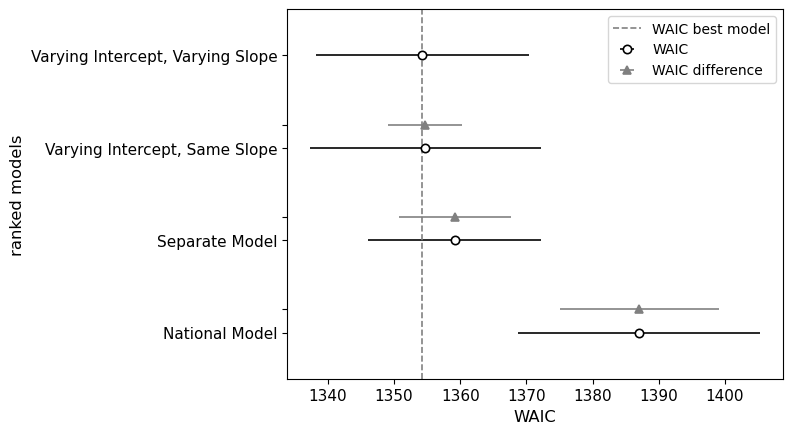

In [39]:
_, axes = plt.subplots(1,1)

az.plot_compare(
    CompareTable
    , textsize = 11
    , figsize = (10,5)
    , ax = axes
    , title =  False
    )

axes.set_xlabel(str.upper(COMPARE_METRIC))
axes.legend([str.upper(COMPARE_METRIC) + " best model", str.upper(COMPARE_METRIC), str.upper(COMPARE_METRIC) + ' difference'])